In [1]:
from pyspark import SparkContext
sc = SparkContext()

In [2]:
!head -10 sample_10e3.json

In [3]:
import json

In [4]:
s = '{ "_id" : { "$oid" : "5cf83b752f3843a016be4e2f" }, "user_day_code" : "e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e42b11adf7c0829341b", "idplug_base" : 21, "user_type" : 1, "idunplug_base" : 8, "travel_time" : 219, "idunplug_station" : 90, "ageRange" : 0, "idplug_station" : 66, "unplug_hourTime" : { "$date" : "2019-06-01T00:00:00.000+0200" }, "zip_code" : "" }'
data = json.loads(s)
data

{'_id': {'$oid': '5cf83b752f3843a016be4e2f'},
 'user_day_code': 'e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e42b11adf7c0829341b',
 'idplug_base': 21,
 'user_type': 1,
 'idunplug_base': 8,
 'travel_time': 219,
 'idunplug_station': 90,
 'ageRange': 0,
 'idplug_station': 66,
 'unplug_hourTime': {'$date': '2019-06-01T00:00:00.000+0200'},
 'zip_code': ''}

In [5]:
rdd_base = sc.textFile('sample_10e3.json')

In [6]:
def mapper(line):
    data = json.loads(line)
    u_t = data['user_type']
    u_c = data['user_day_code']
    start = data['idunplug_station']
    end = data['idplug_station']
    time = data['travel_time']
    return u_t, u_c, start, end, time


In [7]:
rdd = rdd_base.map(mapper)

In [8]:
rdd.take(3)

[(1,
  'e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e42b11adf7c0829341b',
  90,
  66,
  219),
 (1,
  '8a0c4123e924a50a958f51985eb71aea750fb072438035f149283490cc6bfaf4',
  71,
  136,
  359),
 (1,
  'a6a9c1f74a68496000542210abc4fc2eba79e2756ad5355a626632f7783dd418',
  39,
  38,
  375)]

## Usuarios por Tipo

In [9]:
#Sol 1. Partimos de los datos rdd
rdd.countByKey()

defaultdict(int, {1: 954, 2: 10, 3: 36})

In [10]:
#Sol 2. Partimos de los datos originales y definimos un mapeo particular para este caso.
def map_user(line):
    data = json.loads(line)
    u_t = data['user_type']
    return u_t
rdd_base.map(map_user).countByValue()

defaultdict(int, {1: 954, 2: 10, 3: 36})

## Selección de usuarios

In [11]:
#Usando una asignación de variable para seleccionar el tipo
selected_type = 1
rdd_users = rdd.filter(lambda x: x[0]==selected_type).map(lambda x: (x[1],tuple(x[2:])))

In [12]:
rdd_users.take(1)

[('e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e42b11adf7c0829341b',
  (90, 66, 219))]

In [13]:
rdd_users.count()

954

In [14]:
#El RDD no se evalúa, por tanto, si cambiamos el tipo:
selected_type = 2
rdd_users.count()

10

In [15]:
selected_type = 3
rdd_users.count()

36

In [17]:
rdd_users.cache()  # Aunque el rdd no se evalúe se fija el valor de selected type
selected_type = 1
rdd_users.count()

36

## Usuarios con un solo uso diario

In [33]:
select_type = 1
rdd_users = rdd.filter(lambda x: x[0]==selected_type).map(lambda x: (x[1],tuple(x[2:])))
rdd_users.count()

954

In [34]:
rdd_users.groupByKey().mapValues(list).map(lambda x: len(list(x[1]))).take(10)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [35]:
select_type = 2 # Ya he evaluado el rdd. Se queda con el valor 1
rdd_users.count()

954

In [36]:
rdd_users.groupByKey().mapValues(list).map(lambda x: len(x[1])).count()

913

In [37]:
rdd_users.groupByKey().mapValues(tuple).filter(lambda x: len(x[1])==2).count()

39

## Adyacentes ordenados

Una alternativa a considerar es partir de los datos originales rdd_base 
y hacer un mapeo y filtro específico para este problema como vimos en 
la solución al ejercicio Usuarios por Tipo.

Para fomentar la visión de notebook, de trabajo incremental sobre los datos, 
podemos partir de los datos generados/seleccionados previamente en rdd_users 
y quedarnos únicamente con la información que nos interesa: 
origen y destino de los trayectos.

In [38]:
rdd_trips = rdd_users.map(lambda x: (x[1][0], x[1][1]))
rdd_trips.take(10)

[(90, 66),
 (71, 136),
 (39, 38),
 (66, 90),
 (152, 166),
 (55, 53),
 (133, 129),
 (153, 169),
 (44, 129),
 (85, 133)]

In [39]:
rdd_trips.count()

954

In [40]:
# Con un groupBykey agrupamos los trayectos por origen, luego, con los resultados agrupados
# generamos la solución: pares con clave la estación de destino y el valor el número de 
# trayectos que han llegado a ella desde la estación de origen considerada

#Primero la agrupación de adyacentes sin orden ni estructura
rdd_trips.groupByKey().mapValues(tuple).take(2)
#Lo que tenemos que mejorar es la función que utilizamos 
#en los values asociados a cada clave. 

[(90, (66, 74, 55, 57, 58, 48, 82, 46, 26, 26, 128, 122, 149, 83)),
 (66, (90, 90, 141))]

In [41]:
#Utilizamos una función definida. Primero la usamos sólo para contar
def count(values):
    d = {}
    for v in values:
        if v in d:
            d[v] += 1
        else:
            d[v] = 1
    return d
            
rdd_trips.groupByKey().mapValues(count).take(2)



[(90,
  {66: 1,
   74: 1,
   55: 1,
   57: 1,
   58: 1,
   48: 1,
   82: 1,
   46: 1,
   26: 2,
   128: 1,
   122: 1,
   149: 1,
   83: 1}),
 (66, {90: 2, 141: 1})]

In [42]:
#Ahora la mejoramos para que cuente y ordene
def count_and_sort(values):
    d = {}
    for v in values:
        if v in d:
            d[v] += 1
        else:
            d[v] = 1
    return sorted(d.items(), key=lambda x: x[1], reverse=True)
            
rdd_trips.groupByKey().mapValues(count_and_sort).take(2)
#El resultado nos muestra la estación de origen y luego, en una lista pares 
#(estación de destino,número de trayectos), ordenados por número de trayectos.

[(90,
  [(26, 2),
   (66, 1),
   (74, 1),
   (55, 1),
   (57, 1),
   (58, 1),
   (48, 1),
   (82, 1),
   (46, 1),
   (128, 1),
   (122, 1),
   (149, 1),
   (83, 1)]),
 (66, [(90, 2), (141, 1)])]

In [43]:
#Nota: Utilizando algunas funciones definidas podemos ahorrarnos la definición de una 
#función específica

from collections import Counter
rdd_trips.groupByKey().mapValues(Counter).take(3)

[(90,
  Counter({66: 1,
           74: 1,
           55: 1,
           57: 1,
           58: 1,
           48: 1,
           82: 1,
           46: 1,
           26: 2,
           128: 1,
           122: 1,
           149: 1,
           83: 1})),
 (66, Counter({90: 2, 141: 1})),
 (152, Counter({166: 1}))]

## Histograma de viajes por usuario/día

In [44]:
result_dict = rdd_users.groupByKey().mapValues(tuple).mapValues(len).\
                map(lambda x: (x[1],x[0])).countByKey()

In [45]:
print('total de trayectos iniciales', rdd_users.count())
print(result_dict)
#pequeña comprobación
total = 0 
for k,v in result_dict.items():
    total += k*v
print ('total de trayectos en histograma', total)

total de trayectos iniciales 954
defaultdict(<class 'int'>, {1: 873, 2: 39, 3: 1})
total de trayectos en histograma 954


In [46]:
#Para ordenar el diccionario con los resultados por número de viajes
sorted(result_dict.values())

[1, 39, 873]

<ipython-input-47-381e4a0a6661>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


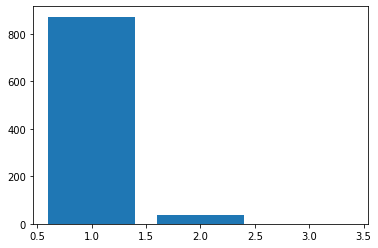

In [47]:
#Una visualización sencilla
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(result_dict.keys(),result_dict.values())
fig.show()
#plt.bar(result_dict.keys(),result_dict.values())

## Return Trips

Dos viajes en un día con el punto de incial de salida igual al final de retorno.

In [48]:
rdd_users.groupByKey().mapValues(tuple)\
    .filter(lambda x: len(x[1])==2).take(10)

[('bdfbb7774e97c37e95c79efa9e5f1cba2f6672dbf1f71c1faa2bc89e9e423ae0',
  ((83, 83, 357), (83, 71, 557))),
 ('666373647f0221920656942700d5aecaf9820af0253d728171bcd720c9626802',
  ((25, 16, 305), (16, 137, 1576))),
 ('6871a6d476dbe4148705858168f1cb3d4e4620d5a12feede1bb8f9e862d1fad3',
  ((151, 115, 406), (115, 90, 171))),
 ('949315079c264a1adf087a270c02f4a6572c852425b8617d0d12a88cef573aac',
  ((83, 2, 698), (1, 83, 656))),
 ('356bb41910f9a3d80a634ae360fdeaf5830d0abd7ca92b565f6f952c46285f92',
  ((117, 120, 1356), (122, 117, 801))),
 ('57e0ec133d5158883595b995ac86a4dca138d769c14dc6b61e10357fdad95c2c',
  ((117, 120, 1350), (122, 117, 713))),
 ('080764552219f227f966f284b84bb88120b4dc04e1b688c316a06204636ed91e',
  ((58, 135, 2477), (135, 34, 1044))),
 ('ad5f0b4b20c30d2916e0ce8054eac8f8286ec2ffcbc7eb35ae07092e953febf2',
  ((18, 7, 526), (7, 8, 127))),
 ('edcf66a3d0535d09d4bdcc488d4fdf203dd7b15eb303af0efebaa6dd2b4e5a35',
  ((55, 86, 273), (86, 79, 468))),
 ('d889e9ad245726c866c1b44fa1882a39979520

In [49]:
def cicle(data):
    p1 = data[1][0]
    p2 = data[1][1]
    return p1[0]==p2[1]

data = ('bdfbb7774e97c37e95c79efa9e5f1cba2f6672dbf1f71c1faa2bc89e9e423ae0',
  ((83, 83, 357), (83, 71, 557)))
print(cicle(data))
data = ('bdfbb7774e97c37e95c79efa9e5f1cba2f6672dbf1f71c1faa2bc89e9e423ae0',
  ((83, 71, 357), (71, 83, 557)))
print(cicle(data))
data = ('bdfbb7774e97c37e95c79efa9e5f1cba2f6672dbf1f71c1faa2bc89e9e423ae0',
  ((83, 2, 357), (1, 83, 557)))
print(cicle(data))


False
True
True


In [50]:
def cicle(data):
    p1 = data[1][0]
    p2 = data[1][1]
    return p1[0]==p2[1]

rdd_return_trip = rdd_users.groupByKey().mapValues(tuple)\
    .filter(lambda x: len(x[1])==2).filter(cicle)

In [51]:
rdd_return_trip.take(10)

[('949315079c264a1adf087a270c02f4a6572c852425b8617d0d12a88cef573aac',
  ((83, 2, 698), (1, 83, 656))),
 ('356bb41910f9a3d80a634ae360fdeaf5830d0abd7ca92b565f6f952c46285f92',
  ((117, 120, 1356), (122, 117, 801))),
 ('57e0ec133d5158883595b995ac86a4dca138d769c14dc6b61e10357fdad95c2c',
  ((117, 120, 1350), (122, 117, 713))),
 ('9b072106db2910a0cd46f2d8d3bc736d4759a742139294b73a37fb73887fbb71',
  ((90, 26, 693), (19, 90, 647))),
 ('b10c476e28ef97b3f1242714f0f9a3acf287bb5e2d882215aa52f51e973400bd',
  ((114, 96, 620), (96, 114, 495))),
 ('bcef457f1234cc899f285eb1d2f99975c919f49c5d9be2fb5875949a63b7745d',
  ((114, 96, 563), (96, 114, 780))),
 ('f7f4cd3b9b0f8c51b63dd63728b79fadf9d09f16306416d7c1ccf40e8961b1a5',
  ((169, 62, 435), (62, 169, 303))),
 ('13b9c8b5ffecc4d2a8c1d27a810d2fa190c05d68b6a1e829ce89185a47310e6e',
  ((125, 6, 499), (6, 125, 510))),
 ('6fb07b5e128af9a6b562f693cc254566caacae7e03881e38e577703e3d53a4d8',
  ((57, 19, 753), (19, 57, 602))),
 ('acdfb28772892164b2e10e47b6ec2309fba28f

De qué estaciones salen el mayor número de viajes de ida y vuelta.

In [52]:
rdd_return_trip.map(lambda x: (x[1][0][0], 1)).take(10)

[(83, 1),
 (117, 1),
 (117, 1),
 (90, 1),
 (114, 1),
 (114, 1),
 (169, 1),
 (125, 1),
 (57, 1),
 (169, 1)]

In [53]:
rdd_return_trip.map(lambda x: (x[1][0][0], 1)).\
  reduceByKey(lambda x,y: x+y).takeOrdered(10, lambda x: -x[1])

[(90, 2),
 (114, 2),
 (117, 2),
 (169, 2),
 (42, 1),
 (83, 1),
 (125, 1),
 (57, 1),
 (129, 1)]